In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import signal, stats
from sklearn import linear_model
import sys
import warnings; warnings.filterwarnings("ignore")

from aux import get_seg
from disp import set_font_size
from my_stats import nanpearsonr

cc = np.concatenate

FPS_DN = 8.5  # sampling rate from neural data
DT_DN = 1/FPS_DN
NT_H_DN = 85
T_H_DN = np.arange(NT_H_DN)*DT_DN

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS
NT_H = int(round(NT_H_DN*FPS/FPS_DN))
T_H = np.arange(NT_H)*DT

H_S_COLS = [f'IT_H_S_{it}' for it in range(NT_H_DN)]
H_P_COLS = [f'IT_H_P_{it}' for it in range(NT_H_DN)]

SAVE_DIR_DYN = 'data/simple/mlv/neur_basic/baker_dyn'
PFX_DYN = 'mlv_baker_dyn'

SAVE_DIR_LIN = 'data/simple/mlv/neur_basic/baker_lin'
PFX_LIN = 'mlv_baker_lin'

SAVE_DIR_LIN2E = 'data/simple/mlv/neur_basic/baker_lin2e'
PFX_LIN2E = 'mlv_baker_lin2e'

SAVE_DIR_LINR = 'data/simple/mlv/neur_basic/baker_linr'
PFX_LINR = 'mlv_baker_linr'

SAVE_DIR_LN = 'data/simple/mlv/neur_basic/baker_ln'
PFX_LN = 'mlv_baker_ln'

SAVE_DIR_LN2E = 'data/simple/mlv/neur_basic/baker_ln2e'
PFX_LN2E = 'mlv_baker_ln2e'

SAVE_DIR_LNR = 'data/simple/mlv/neur_basic/baker_lnr'
PFX_LNR = 'mlv_baker_lnr'

SAVE_DIR_MASOFF = 'data/simple/mlv/neur_basic/baker_masoff'
PFX_MASOFF = 'mlv_baker_masoff'

if not os.path.exists(SAVE_DIR_DYN):
    os.makedirs(SAVE_DIR_DYN)
if not os.path.exists(SAVE_DIR_LIN):
    os.makedirs(SAVE_DIR_LIN)
if not os.path.exists(SAVE_DIR_LIN2E):
    os.makedirs(SAVE_DIR_LIN2E)
if not os.path.exists(SAVE_DIR_LINR):
    os.makedirs(SAVE_DIR_LINR)
if not os.path.exists(SAVE_DIR_LN):
    os.makedirs(SAVE_DIR_LN)
if not os.path.exists(SAVE_DIR_LN2E):
    os.makedirs(SAVE_DIR_LN2E)
if not os.path.exists(SAVE_DIR_LNR):
    os.makedirs(SAVE_DIR_LNR)
if not os.path.exists(SAVE_DIR_MASOFF):
    os.makedirs(SAVE_DIR_MASOFF)

Load either Coen or WT Gold behavior data

In [2]:
df_behav = pd.read_csv('data/simple/c_song_f_behav.csv')
CTR_OFFSET = 0

# df_behav = pd.read_csv('data/simple/w_song_f_behav.csv')
# CTR_OFFSET = 276

df_behav

,ID,FRAME,T,Q,S,P,F,FFV,FFA,FLS,FRS,FMFV,FMLS
0,0,0,0.000000,1,0,0,0,0.231,0.0000,0.159,0.077,-0.058526,0.274257
1,0,1,0.033300,1,0,0,0,0.314,0.0385,0.025,0.044,0.100623,0.298490
2,0,2,0.066600,1,0,0,0,0.308,0.0025,0.029,0.011,0.147629,0.271865
3,0,3,0.099900,1,0,0,0,0.319,0.0020,0.016,0.016,0.091174,0.306112
4,0,4,0.133200,1,0,0,0,0.312,-0.0315,0.030,0.002,0.065871,0.306439
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4978565,275,27100,902.430902,1,0,0,0,0.217,0.0280,0.029,0.058,-0.171418,0.136184
4978566,275,27101,902.464202,1,0,0,0,0.210,-0.1045,0.138,0.322,0.032522,0.249171
4978567,275,27102,902.497502,1,0,0,0,0.008,-0.0910,0.034,0.260,0.033202,0.010844
4978568,275,27103,902.530803,1,0,0,0,0.028,0.0695,0.010,0.090,0.012059,0.027177


In [3]:
# split big df into dfs for individual trials
ntr = np.max(df_behav.ID) + 1
dfs_tr = [df_behav[df_behav.ID == i] for i in range(ntr)]

tr_lens = np.array([len(df_tr) for df_tr in dfs_tr])
tr_lens_cum = cc([[0], np.cumsum(tr_lens)])

n_t_total = np.sum(tr_lens)
assert n_t_total == tr_lens_cum[-1]
df_behav = None

# MA: Multiplicative-adaption dynamical system neural responses

Load params from dynamical systems fits to Baker et al data

In [4]:
# neural response fits from Baker data
df_dyn_param = pd.read_csv('data/simple/neur/baker_dyn_fit_param.csv')
df_dyn_param

,EXPT_ID,LINE,FLY,ROI,ROI_USED,FIT_ERR,SUCCESS,T_0,R_0,TAU_R,TAU_A,X_S,X_P
0,0,R70G01,0,somas,False,0.275200,True,-0.000000,0.028882,6.202615,30.336758,-4.958290,-2.597432
1,1,R70G01,1,somas,False,0.186212,True,0.117647,0.025128,3.835468,21.821295,-4.163967,-1.472075
2,2,R70G01,2,somas,False,0.248414,True,-0.000000,0.055962,6.017162,15.058055,-6.248007,-2.095952
3,3,R70G01,3,somas,False,0.455963,True,-0.000000,-0.014227,6.016828,11.820576,-5.679735,-2.118245
4,4,R70G01,4,somas,False,0.229018,True,-0.000000,0.019831,6.434825,55.496220,-4.415761,-2.863647
...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,219,VT34811,0,somas,False,0.276087,True,-0.000000,0.039119,1.799608,1440.994269,-0.049828,2.494657
220,220,VT34811,0,ascending projection,False,0.037801,True,-0.000000,-0.001886,1.298841,27.643238,0.098451,2.457383
221,221,vPN1_split,0,somas,False,0.404112,True,-0.588235,-0.014702,4.151226,6.155551,8.332263,2.353217
222,222,vPN1_split,1,somas,False,1.205977,True,0.235294,-0.095665,5.924070,90.705238,2.390705,0.604586


In [5]:
expt_ids = df_dyn_param['EXPT_ID']

# get parameters
tau_rs = np.array(df_dyn_param['TAU_R'])
tau_as = np.array(df_dyn_param['TAU_A'])
x_ss = np.array(df_dyn_param['X_S'])
x_ps = np.array(df_dyn_param['X_P'])

In [6]:
# define smln & obj function
def smlt(i_s, i_p, tau_r, tau_a, x_s, x_p):
    """Simulate response to song inputs."""
    t = np.arange(len(i_s))*DT
    r = np.nan*np.zeros(len(t))
    
    r[0] = 0
    a_s, a_p = 0, 0
    
    for ct, t_ in enumerate(t[1:], 1):
        a_s += ((DT/tau_a) * (-a_s + x_s*i_s[ct]))
        a_p += ((DT/tau_a) * (-a_p + x_p*i_p[ct]))
        r[ct] = r[ct-1] + (DT/tau_r) * (-r[ct-1] + (x_s - a_s)*i_s[ct] + (x_p - a_p)*i_p[ct])
    
    return r

In [7]:
# compute surrogate neural responses for each trial
for ctr, df_tr in enumerate(dfs_tr):
    df_tr_nrl_dyn = df_tr.copy()
    sys.stdout.write('.')
    # loop over neurons
    for expt_id, tau_r, tau_a, x_s, x_p in zip(expt_ids, tau_rs, tau_as, x_ss, x_ps):
        # compute surrogate neural response
        i_s = np.array(df_tr['S']).astype(float)
        i_p = np.array(df_tr['P'] | df_tr['F']).astype(float)
        
        r = smlt(i_s, i_p, tau_r, tau_a, x_s, x_p)
        
        df_tr_nrl_dyn[f'R_{expt_id}'] = r
        
    np.save(os.path.join(SAVE_DIR_DYN, f'{PFX_DYN}_tr_{ctr+CTR_OFFSET}.npy'), np.array([{'df': df_tr_nrl_dyn}]))

....................................................................................

# LIN: Linear neural responses

Load params from linear fits on Baker et al data.

In [4]:
# neural response fits from Baker data
df_lin_param = pd.read_csv('data/simple/neur/baker_lin_fit_param.csv')
df_lin_param

,EXPT_ID,LINE,FLY,ROI,ROI_USED,FIT_ERR,SUCCESS,IDUR_H,T_0,R_0,...,IT_H_P_75,IT_H_P_76,IT_H_P_77,IT_H_P_78,IT_H_P_79,IT_H_P_80,IT_H_P_81,IT_H_P_82,IT_H_P_83,IT_H_P_84
0,0,R70G01,0,somas,False,0.174497,1,85,0.235294,0,...,-0.154953,-0.073905,-0.007819,-0.506101,0.231079,0.131478,0.380165,1.043530,0.523804,-2.027452
1,1,R70G01,1,somas,False,0.173904,1,85,0.235294,0,...,-0.808924,0.464651,-0.320987,0.582338,0.282897,-0.153832,-0.394784,1.707338,-0.719647,-0.152941
2,2,R70G01,2,somas,False,0.170188,1,85,0.235294,0,...,-0.339182,0.267191,0.125736,-0.641290,0.483302,-0.417439,0.945032,1.250669,-0.291958,-0.910192
3,3,R70G01,3,somas,False,0.365310,1,85,0.235294,0,...,-1.042894,1.202923,-2.168054,0.977008,-0.909011,-1.937358,3.046854,-1.023927,0.129524,-1.712622
4,4,R70G01,4,somas,False,0.153828,1,85,0.235294,0,...,-0.511628,-0.399655,-0.150975,-0.333150,-0.033365,0.079399,0.435384,0.419418,0.733692,-2.437793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,219,VT34811,0,somas,False,0.220064,1,85,-0.470588,0,...,-1.653836,2.237410,-0.589508,-0.483772,1.333863,2.307638,-1.417966,-0.412455,-1.430931,0.913422
220,220,VT34811,0,ascending projection,False,0.066786,1,85,-0.705882,0,...,-0.013608,0.071371,-0.077927,-0.024410,-0.102891,0.050893,0.021110,-0.073407,0.014354,0.555983
221,221,vPN1_split,0,somas,False,0.421309,1,85,-0.941176,0,...,-0.091841,2.063789,-1.226476,-0.652369,2.441115,0.451942,-0.476302,3.120248,-0.000051,-2.094935
222,222,vPN1_split,1,somas,False,0.923838,1,85,-0.705882,0,...,9.607118,3.330856,-7.545851,4.314196,4.479567,-5.405843,-4.439488,12.160638,-2.870428,-9.383391


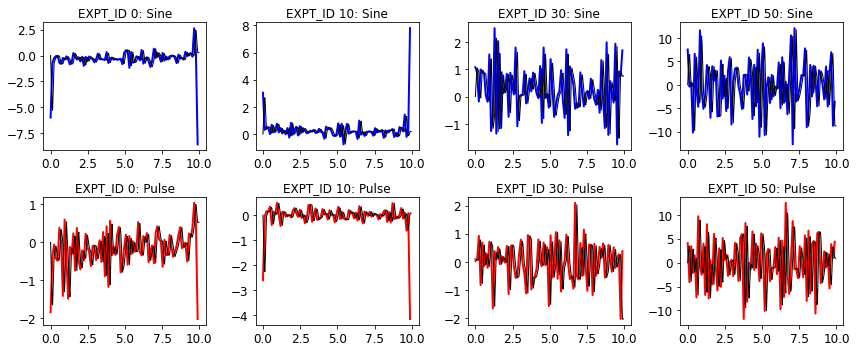

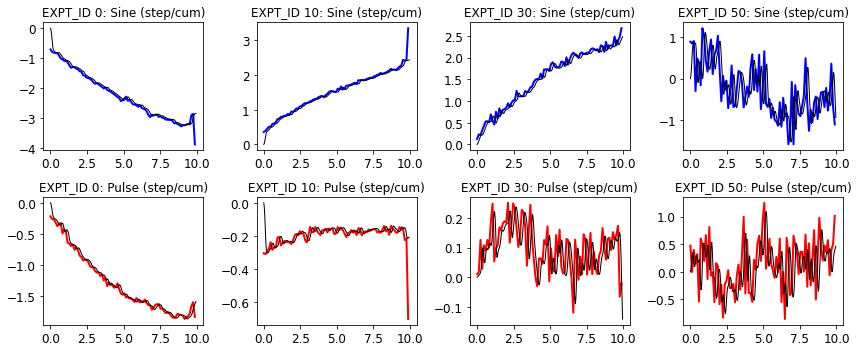

In [5]:
expt_ids = df_lin_param['EXPT_ID']

# extract filters (downsampled)
hs_dn_s = np.array([df_lin_param[expt_ids == expt_id].iloc[0][H_S_COLS] for expt_id in expt_ids]).astype(float)
hs_dn_p = np.array([df_lin_param[expt_ids == expt_id].iloc[0][H_P_COLS] for expt_id in expt_ids]).astype(float)

# upsample filters via interpolation
hs_s = np.array([np.interp(T_H, T_H_DN, cc([[0], h_dn_s])[:-1]) for h_dn_s in hs_dn_s])
hs_p = np.array([np.interp(T_H, T_H_DN, cc([[0], h_dn_p])[:-1]) for h_dn_p in hs_dn_p])

fig, axs = plt.subplots(2, 4, figsize=(12, 5), tight_layout=True)
for cexpt, ax_col in zip([0, 10, 30, 50], axs.T):
    ax_col[0].plot(T_H_DN, hs_dn_s[cexpt], c='b', lw=2)
    ax_col[0].plot(T_H, hs_s[cexpt], c='k', lw=1)
    ax_col[0].set_title(f'EXPT_ID {expt_ids[cexpt]}: Sine')
    
    ax_col[1].plot(T_H_DN, hs_dn_p[cexpt], c='r', lw=2)
    ax_col[1].plot(T_H, hs_p[cexpt], c='k', lw=1)
    ax_col[1].set_title(f'EXPT_ID {expt_ids[cexpt]}: Pulse')
    
set_font_size(axs, 12)

fig, axs = plt.subplots(2, 4, figsize=(12, 5), tight_layout=True)
for cexpt, ax_col in zip([0, 10, 30, 50], axs.T):
    ax_col[0].plot(T_H_DN, hs_dn_s[cexpt].cumsum()*DT_DN, c='b', lw=2)
    ax_col[0].plot(T_H, hs_s[cexpt].cumsum()*DT, c='k', lw=1)
    ax_col[0].set_title(f'EXPT_ID {expt_ids[cexpt]}: Sine (step/cum)')
    
    ax_col[1].plot(T_H_DN, hs_dn_p[cexpt].cumsum()*DT_DN, c='r', lw=2)
    ax_col[1].plot(T_H, hs_p[cexpt].cumsum()*DT, c='k', lw=1)
    ax_col[1].set_title(f'EXPT_ID {expt_ids[cexpt]}: Pulse (step/cum)')
    
set_font_size(axs, 12)

Neural responses are given by convolution of each neuron's impulse response with song

$$r(t) = h_{sine}(t) \circledast I_{sine}(t) + h_{pulse}(t) \circledast I_{pulse}(t) = \int_0^{\infty} h_{sine}(t') I_{sine}(t-t')dt' + \int_0^{\infty} h_{pulse}(t') I_{pulse}(t-t')dt'$$

In [6]:
# compute surrogate linear neural responses for each trial
for ctr, df_tr in enumerate(dfs_tr):
    df_tr_nrl_lin = df_tr.copy()
    sys.stdout.write('.')
    # loop over neurons
    for expt_id, h_s, h_p in zip(expt_ids, hs_s, hs_p):
        # compute surrogate neural response
        i_s = np.array(df_tr['S']).astype(float)
        i_p = np.array(df_tr['P'] | df_tr['F']).astype(float)
        
        r = DT*(signal.fftconvolve(i_s, h_s, mode='full')[:len(i_s)] \
            + signal.fftconvolve(i_p, h_p, mode='full')[:len(i_p)])
        
        df_tr_nrl_lin[f'R_{expt_id}'] = r
        
    np.save(os.path.join(SAVE_DIR_LIN, f'{PFX_LIN}_tr_{ctr+CTR_OFFSET}.npy'), np.array([{'df': df_tr_nrl_lin}]))

....................................................................................

# LIN2E: Two-exponential linear neural responses

In [4]:
# neural response fits from Baker data
df_lin2e_param = pd.read_csv('data/simple/neur/baker_lin2e_fit_param.csv')
df_lin2e_param

,EXPT_ID,LINE,FLY,ROI,ROI_USED,FIT_ERR,SUCCESS,IDUR_H,T_0,R_0,X_S_0,TAU_S_0,X_S_1,TAU_S_1,X_P_0,TAU_P_0,X_P_1,TAU_P_1
0,0,R70G01,0,somas,False,0.229106,1,85,0.117647,-0.059190,-5.097073,0.001000,-0.312825,165.813205,-709.253290,49.173187,708.868640,49.312735
1,1,R70G01,1,somas,False,0.196160,1,85,-0.000000,-0.010934,-0.875610,2.360084,-0.114297,44.207160,-1211.498176,79.266232,1211.252976,79.412287
2,2,R70G01,2,somas,False,0.255075,1,85,0.235294,-0.054682,-1.666718,0.684494,-0.265020,2113.926184,-1241.704637,386.640935,1241.394353,391.658764
3,3,R70G01,3,somas,False,0.473779,1,85,0.235294,-0.080619,-1.127434,1.121859,-0.193948,9187.843155,-3.396952,0.001000,-0.078372,2053.808844
4,4,R70G01,4,somas,False,0.228553,1,85,0.235294,-0.064880,-2.240760,0.167816,-0.314796,55.847693,-0.471086,2.477134,-0.101721,55.477222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,219,VT34811,0,somas,False,0.272680,1,85,-0.000000,0.017155,-0.654393,114.100544,0.630867,1440.994816,1.508601,1.440642,0.028748,1440.994770
220,220,VT34811,0,ascending projection,False,0.078037,1,85,-0.000000,0.017014,0.054336,1.292750,-0.002234,27.643159,1.844651,1.092712,-0.018310,27.628087
221,221,vPN1_split,0,somas,False,0.497124,1,85,-0.117647,0.085370,3.373222,0.708289,0.103190,2770.866017,0.013577,1602.998920,0.684729,1.046493
222,222,vPN1_split,1,somas,False,1.170604,1,85,0.235294,-0.038720,0.143605,2.324336,0.163889,90.954773,167.248944,91.179925,-166.988657,93.542411


In [5]:
expt_ids = df_lin2e_param['EXPT_ID']

# get parameters
x_s_0s = np.array(df_lin2e_param['X_S_0'])
tau_s_0s = np.array(df_lin2e_param['TAU_S_0'])
x_s_1s = np.array(df_lin2e_param['X_S_1'])
tau_s_1s = np.array(df_lin2e_param['TAU_S_1'])
x_p_0s = np.array(df_lin2e_param['X_P_0'])
tau_p_0s = np.array(df_lin2e_param['TAU_P_0'])
x_p_1s = np.array(df_lin2e_param['X_P_1'])
tau_p_1s = np.array(df_lin2e_param['TAU_P_1'])

In [6]:
# define smln & obj function
def smlt(i_s, i_p, x_s_0, tau_s_0, x_s_1, tau_s_1, x_p_0, tau_p_0, x_p_1, tau_p_1):
    """Simulate response to sine or pulse inputs."""
    h_s = x_s_0*np.exp(-T_H/tau_s_0) + x_s_1*np.exp(-T_H/tau_s_1)
    h_p = x_p_0*np.exp(-T_H/tau_p_0) + x_p_1*np.exp(-T_H/tau_p_1)

    r = signal.fftconvolve(i_s, h_s, mode='full')[:len(i_s)]*DT + signal.fftconvolve(i_p, h_p, mode='full')[:len(i_p)]*DT
    return r

In [7]:
# compute surrogate neural responses for each trial
for ctr, df_tr in enumerate(dfs_tr):
    df_tr_nrl_lin2e = df_tr.copy()
    sys.stdout.write('.')
    # loop over neurons
    for params in zip(expt_ids, x_s_0s, tau_s_0s, x_s_1s, tau_s_1s, x_p_0s, tau_p_0s, x_p_1s, tau_p_1s):
        expt_id = params[0]
        
        x_s_0, tau_s_0, x_s_1, tau_s_1 = params[1:5]
        x_p_0, tau_p_0, x_p_1, tau_p_1  = params[5:9]
        
        # compute surrogate neural response
        i_s = np.array(df_tr['S']).astype(float)
        i_p = np.array(df_tr['P'] | df_tr['F']).astype(float)
        
        r = smlt(i_s, i_p, x_s_0, tau_s_0, x_s_1, tau_s_1, x_p_0, tau_p_0, x_p_1, tau_p_1)
        
        df_tr_nrl_lin2e[f'R_{expt_id}'] = r
        
    np.save(os.path.join(SAVE_DIR_LIN2E, f'{PFX_LIN2E}_tr_{ctr+CTR_OFFSET}.npy'), np.array([{'df': df_tr_nrl_lin2e}]))

....................................................................................................................................................................................................................................................................................

# LINR: Linear neural responses (fit with ridge regression)

Load params from linear-ridge fits on Baker et al data.

In [4]:
# neural response fits from Baker data
df_linr_param = pd.read_csv('data/simple/neur/baker_linr_fit_param.csv')
df_linr_param

,EXPT_ID,LINE,FLY,ROI,ROI_USED,FIT_ERR,SUCCESS,IDUR_H,T_0,R_0,...,IT_H_P_75,IT_H_P_76,IT_H_P_77,IT_H_P_78,IT_H_P_79,IT_H_P_80,IT_H_P_81,IT_H_P_82,IT_H_P_83,IT_H_P_84
0,0,R70G01,0,somas,False,0.222650,1,85,-0.235294,0,...,-0.093739,-0.062072,-0.028234,-0.011731,-0.028225,-0.034580,-0.037790,-0.043398,-0.011989,-0.000026
1,1,R70G01,1,somas,False,0.191981,1,85,-0.000000,0,...,-0.051638,-0.038048,-0.055748,-0.005039,0.023916,0.096354,0.100573,0.132591,0.140996,0.162758
2,2,R70G01,2,somas,False,0.226315,1,85,0.117647,0,...,0.033358,0.022132,0.039811,0.039299,0.031872,0.078299,0.092325,0.147132,0.144068,0.096739
3,3,R70G01,3,somas,False,0.418063,1,85,-0.000000,0,...,-0.206687,-0.065703,-0.083107,-0.196977,-0.176666,-0.254149,-0.305501,-0.351011,-0.297465,-0.292165
4,4,R70G01,4,somas,False,0.197886,1,85,0.117647,0,...,-0.074949,-0.125000,-0.144121,-0.142800,-0.140825,-0.123463,-0.113310,-0.118573,-0.137914,-0.179548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,219,VT34811,0,somas,False,0.260305,1,85,-0.823529,0,...,0.030141,0.017547,-0.042399,-0.052896,-0.002514,0.117717,0.139559,0.135838,0.189340,0.098493
220,220,VT34811,0,ascending projection,False,0.079575,1,85,-0.705882,0,...,0.000731,0.002116,-0.002039,-0.000123,0.003736,0.016126,0.025734,0.035711,0.054418,0.076331
221,221,vPN1_split,0,somas,False,0.476190,1,85,-0.941176,0,...,0.018103,0.143587,0.115454,0.194676,0.341662,0.320691,0.289220,0.318991,0.124661,-0.059691
222,222,vPN1_split,1,somas,False,1.112980,1,85,0.235294,0,...,0.017576,-0.073813,0.074422,-0.422236,-0.277067,-0.599437,-0.296234,-1.228730,-1.195256,-1.196209


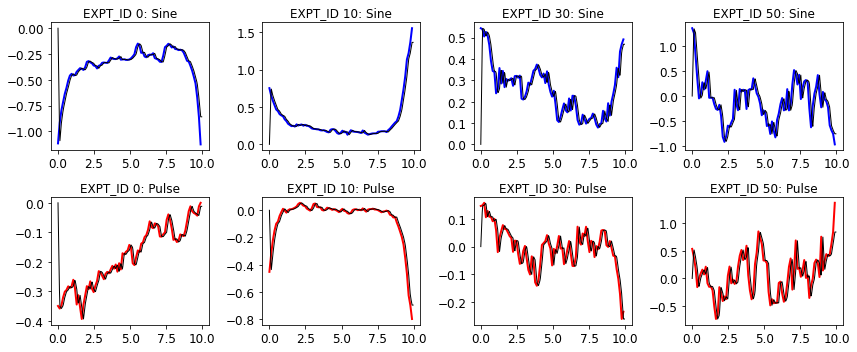

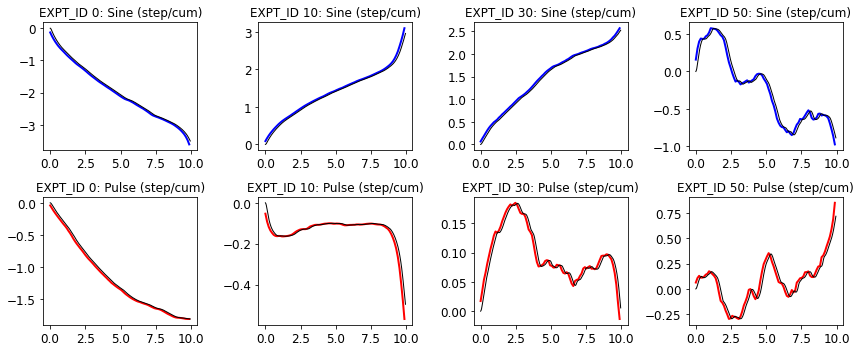

In [5]:
expt_ids = df_linr_param['EXPT_ID']

# extract filters (downsampled)
hs_dn_s = np.array([df_linr_param[expt_ids == expt_id].iloc[0][H_S_COLS] for expt_id in expt_ids]).astype(float)
hs_dn_p = np.array([df_linr_param[expt_ids == expt_id].iloc[0][H_P_COLS] for expt_id in expt_ids]).astype(float)

# upsample filters via interpolation
hs_s = np.array([np.interp(T_H, T_H_DN, cc([[0], h_dn_s])[:-1]) for h_dn_s in hs_dn_s])
hs_p = np.array([np.interp(T_H, T_H_DN, cc([[0], h_dn_p])[:-1]) for h_dn_p in hs_dn_p])

fig, axs = plt.subplots(2, 4, figsize=(12, 5), tight_layout=True)
for cexpt, ax_col in zip([0, 10, 30, 50], axs.T):
    ax_col[0].plot(T_H_DN, hs_dn_s[cexpt], c='b', lw=2)
    ax_col[0].plot(T_H, hs_s[cexpt], c='k', lw=1)
    ax_col[0].set_title(f'EXPT_ID {expt_ids[cexpt]}: Sine')
    
    ax_col[1].plot(T_H_DN, hs_dn_p[cexpt], c='r', lw=2)
    ax_col[1].plot(T_H, hs_p[cexpt], c='k', lw=1)
    ax_col[1].set_title(f'EXPT_ID {expt_ids[cexpt]}: Pulse')
    
set_font_size(axs, 12)

fig, axs = plt.subplots(2, 4, figsize=(12, 5), tight_layout=True)
for cexpt, ax_col in zip([0, 10, 30, 50], axs.T):
    ax_col[0].plot(T_H_DN, hs_dn_s[cexpt].cumsum()*DT_DN, c='b', lw=2)
    ax_col[0].plot(T_H, hs_s[cexpt].cumsum()*DT, c='k', lw=1)
    ax_col[0].set_title(f'EXPT_ID {expt_ids[cexpt]}: Sine (step/cum)')
    
    ax_col[1].plot(T_H_DN, hs_dn_p[cexpt].cumsum()*DT_DN, c='r', lw=2)
    ax_col[1].plot(T_H, hs_p[cexpt].cumsum()*DT, c='k', lw=1)
    ax_col[1].set_title(f'EXPT_ID {expt_ids[cexpt]}: Pulse (step/cum)')
    
set_font_size(axs, 12)

Neural responses are given by convolution of each neuron's impulse response with song

$$r(t) = h_{sine}(t) \circledast I_{sine}(t) + h_{pulse}(t) \circledast I_{pulse}(t) = \int_0^{\infty} h_{sine}(t') I_{sine}(t-t')dt' + \int_0^{\infty} h_{pulse}(t') I_{pulse}(t-t')dt'$$

In [6]:
# compute surrogate linear neural responses for each trial
for ctr, df_tr in enumerate(dfs_tr):
    df_tr_nrl_linr = df_tr.copy()
    sys.stdout.write('.')
    # loop over neurons
    for expt_id, h_s, h_p in zip(expt_ids, hs_s, hs_p):
        # compute surrogate neural response
        i_s = np.array(df_tr['S']).astype(float)
        i_p = np.array(df_tr['P'] | df_tr['F']).astype(float)
        
        r = DT*(signal.fftconvolve(i_s, h_s, mode='full')[:len(i_s)] \
            + signal.fftconvolve(i_p, h_p, mode='full')[:len(i_p)])
        
        df_tr_nrl_linr[f'R_{expt_id}'] = r
        
    np.save(os.path.join(SAVE_DIR_LINR, f'{PFX_LINR}_tr_{ctr+CTR_OFFSET}.npy'), np.array([{'df': df_tr_nrl_linr}]))

....................................................................................

# LN: Linear-nonlinear neural responses

Load params from LN fits on Baker et al data.

In [7]:
# neural response fits from Baker data
df_ln_param = pd.read_csv('data/simple/neur/baker_ln_fit_param.csv')
df_ln_param

,EXPT_ID,LINE,FLY,ROI,ROI_USED,FIT_ERR,SUCCESS,IDUR_H,T_0,R_MIN,...,IT_H_P_75,IT_H_P_76,IT_H_P_77,IT_H_P_78,IT_H_P_79,IT_H_P_80,IT_H_P_81,IT_H_P_82,IT_H_P_83,IT_H_P_84
0,0,R70G01,0,somas,False,0.116654,1,85,-0.588235,-3.415529,...,-0.734095,0.811377,-0.067731,-0.257040,-0.137581,0.384149,-0.360587,0.417339,0.160589,-0.026703
1,1,R70G01,1,somas,False,0.157722,1,85,-0.000000,-4.455353,...,-1.188191,0.431265,-0.379593,-0.141001,0.257382,0.720318,0.031915,1.152158,0.097212,-0.539837
2,2,R70G01,2,somas,False,0.216238,1,85,-0.705882,-9.401333,...,-0.216395,1.049489,-0.652327,-0.892429,2.073636,-0.499193,-0.163227,-0.592688,0.768063,0.935336
3,3,R70G01,3,somas,False,0.399637,1,85,-0.000000,-10.427291,...,-1.732860,-0.250369,1.469324,-2.890671,3.226214,-3.175536,-0.105929,-1.195380,-1.886349,1.462493
4,4,R70G01,4,somas,False,0.157962,1,85,-0.000000,-4.234239,...,-0.107905,0.067871,-0.247231,-0.176038,-0.245665,-0.303530,0.276232,0.114832,0.014329,-0.277528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,219,VT34811,0,somas,False,0.240074,1,85,-0.941176,-2.651729,...,-0.270258,0.708970,2.826822,-2.624359,-0.652230,0.865368,-0.779340,1.182712,0.918672,1.639929
220,220,VT34811,0,ascending projection,False,0.066822,1,85,-0.705882,-1.838089,...,0.120907,0.086056,-0.028436,-0.045641,-0.214481,0.216249,0.101994,0.017857,0.183708,0.556504
221,221,vPN1_split,0,somas,False,0.449277,1,85,-0.352941,-7.514724,...,2.654589,-1.975776,1.694190,0.508859,-3.986838,1.630318,-2.643436,-0.427851,2.896510,0.766496
222,222,vPN1_split,1,somas,False,1.020438,1,85,-0.705882,-9.407223,...,9.664129,12.435059,-12.459662,3.377176,6.525184,-3.782298,-15.511553,16.338576,-4.705969,-6.501855


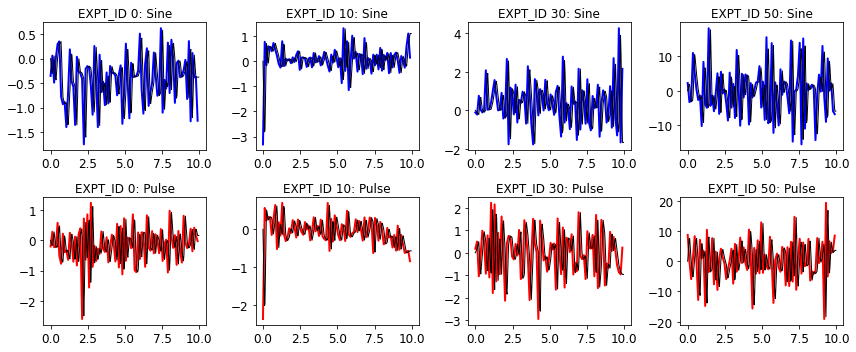

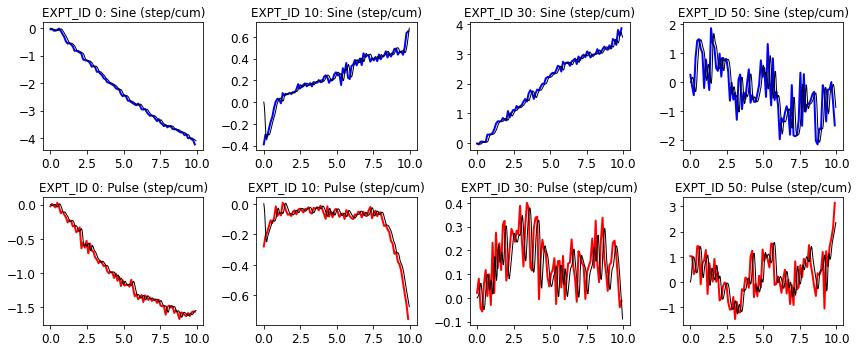

In [8]:
expt_ids = df_ln_param['EXPT_ID']

r_mins = np.array([df_ln_param[expt_ids == expt_id].iloc[0]['R_MIN'] for expt_id in expt_ids])
r_maxs = np.array([df_ln_param[expt_ids == expt_id].iloc[0]['R_MAX'] for expt_id in expt_ids])
z_0s = np.array([df_ln_param[expt_ids == expt_id].iloc[0]['Z_0'] for expt_id in expt_ids])
betas = np.array([df_ln_param[expt_ids == expt_id].iloc[0]['BETA'] for expt_id in expt_ids])

# extract filters (downsampled)
hs_dn_s = np.array([df_ln_param[expt_ids == expt_id].iloc[0][H_S_COLS] for expt_id in expt_ids]).astype(float)
hs_dn_p = np.array([df_ln_param[expt_ids == expt_id].iloc[0][H_P_COLS] for expt_id in expt_ids]).astype(float)

# # upsample filters via interpolation
hs_s = np.array([np.interp(T_H, T_H_DN, cc([[0], h_dn_s])[:-1]) for h_dn_s in hs_dn_s])
hs_p = np.array([np.interp(T_H, T_H_DN, cc([[0], h_dn_p])[:-1]) for h_dn_p in hs_dn_p])

fig, axs = plt.subplots(2, 4, figsize=(12, 5), tight_layout=True)
for cexpt, ax_col in zip([0, 10, 30, 50], axs.T):
    ax_col[0].plot(T_H_DN, hs_dn_s[cexpt], c='b', lw=2)
    ax_col[0].plot(T_H, hs_s[cexpt], c='k', lw=1)
    ax_col[0].set_title(f'EXPT_ID {expt_ids[cexpt]}: Sine')
    
    ax_col[1].plot(T_H_DN, hs_dn_p[cexpt], c='r', lw=2)
    ax_col[1].plot(T_H, hs_p[cexpt], c='k', lw=1)
    ax_col[1].set_title(f'EXPT_ID {expt_ids[cexpt]}: Pulse')
    
set_font_size(axs, 12)

fig, axs = plt.subplots(2, 4, figsize=(12, 5), tight_layout=True)
for cexpt, ax_col in zip([0, 10, 30, 50], axs.T):
    ax_col[0].plot(T_H_DN, hs_dn_s[cexpt].cumsum()*DT_DN, c='b', lw=2)
    ax_col[0].plot(T_H, hs_s[cexpt].cumsum()*DT, c='k', lw=1)
    ax_col[0].set_title(f'EXPT_ID {expt_ids[cexpt]}: Sine (step/cum)')
    
    ax_col[1].plot(T_H_DN, hs_dn_p[cexpt].cumsum()*DT_DN, c='r', lw=2)
    ax_col[1].plot(T_H, hs_p[cexpt].cumsum()*DT, c='k', lw=1)
    ax_col[1].set_title(f'EXPT_ID {expt_ids[cexpt]}: Pulse (step/cum)')
    
set_font_size(axs, 12)

Neural responses are given by convolution of each neuron's impulse response with song
$$z(t) = h_{sine}(t) \circledast I_{sine}(t) + h_{pulse}(t) \circledast I_{pulse}(t)$$

$$r(t) = r_{min} + (r_{max} - r_{min})\left[\frac{\tanh(\beta(z - z_0)) - 1}{2}\right]$$

In [9]:
def smlt(i_s, i_p, h_s, h_p, r_min, r_max, z_0, beta):
    """Simulate response to song inputs."""
    z = DT*(signal.fftconvolve(i_s, h_s, mode='full')[:len(i_s)] + signal.fftconvolve(i_p, h_p, mode='full')[:len(i_p)])
    
    return r_min + (r_max-r_min)*(np.tanh(beta*(z-z_0)) + 1)/2


# compute surrogate neural responses for each trial
for ctr, df_tr in enumerate(dfs_tr):
    df_tr_nrl_ln = df_tr.copy()
    sys.stdout.write('.')
    # loop over neurons
    for expt_id, h_s, h_p, r_min, r_max, z_0, beta in zip(expt_ids, hs_s, hs_p, r_mins, r_maxs, z_0s, betas):
        # compute surrogate neural response
        i_s = np.array(df_tr['S']).astype(float)
        i_p = np.array(df_tr['P'] | df_tr['F']).astype(float)
        
        r = smlt(i_s, i_p, h_s, h_p, r_min, r_max, z_0, beta)
        df_tr_nrl_ln[f'R_{expt_id}'] = r
        
    np.save(os.path.join(SAVE_DIR_LN, f'{PFX_LN}_tr_{ctr+CTR_OFFSET}.npy'), np.array([{'df': df_tr_nrl_ln}]))

....................................................................................

# LN2E: Two-exponential linear-nonlinear neural responses

In [8]:
# neural response fits from Baker data
df_ln2e_param = pd.read_csv('data/simple/neur/baker_ln2e_fit_param.csv')
df_ln2e_param

,EXPT_ID,LINE,FLY,ROI,ROI_USED,FIT_ERR,SUCCESS,IDUR_H,T_0,R_0,...,X_S_1,TAU_S_1,X_P_0,TAU_P_0,X_P_1,TAU_P_1,R_MIN,R_MAX,Z_0,BETA
0,0,R70G01,0,somas,False,0.117560,1,85,-0.000000,NaN,...,-0.154191,30.180363,-3.961294,26.948504,3.787005,30.630950,-3.381946,7.398916,0.671628,0.583010
1,1,R70G01,1,somas,False,0.158858,1,85,0.117647,NaN,...,-0.013565,21.753526,-4.049267,20.172798,3.902730,22.053586,-3.706495,8.188287,0.987402,0.400469
2,2,R70G01,2,somas,False,0.191264,1,85,0.235294,NaN,...,-0.764675,6.530992,-225.405985,50.045630,225.147387,50.422539,-3.857243,10.035773,1.907539,0.252120
3,3,R70G01,3,somas,False,0.442547,1,85,0.235294,NaN,...,-0.696203,15.725203,-1.791570,0.387985,-0.266678,12.185476,-3.277827,9.984575,5.376108,0.105360
4,4,R70G01,4,somas,False,0.179375,1,85,0.117647,NaN,...,-0.374162,55.459681,-0.545149,7.009295,0.083337,55.496544,-3.774448,8.738981,1.878088,0.225724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,219,VT34811,0,somas,False,0.273983,1,85,-0.000000,NaN,...,0.008059,1440.994266,1.755510,1.389889,0.043692,1440.994267,-1.315365,4.037645,1.577971,0.348053
220,220,VT34811,0,ascending projection,False,0.076723,1,85,-0.000000,NaN,...,-0.004666,27.642668,4.725851,1.098195,-0.046660,27.626202,-6.206005,6.536448,0.375284,0.062548
221,221,vPN1_split,0,somas,False,0.379871,1,85,-0.000000,NaN,...,0.264978,7.350327,0.963394,0.497237,0.090109,5.033177,-8.823967,3.274269,-2.007860,0.248950
222,222,vPN1_split,1,somas,False,1.166182,1,85,0.235294,NaN,...,-142.865338,91.318485,8.985745,48.286775,-8.506011,90.451418,-10.065268,2.044586,-4.322561,0.180781


In [9]:
expt_ids = df_ln2e_param['EXPT_ID']

# get parameters
x_s_0s = np.array(df_ln2e_param['X_S_0'])
tau_s_0s = np.array(df_ln2e_param['TAU_S_0'])
x_s_1s = np.array(df_ln2e_param['X_S_1'])
tau_s_1s = np.array(df_ln2e_param['TAU_S_1'])
x_p_0s = np.array(df_ln2e_param['X_P_0'])
tau_p_0s = np.array(df_ln2e_param['TAU_P_0'])
x_p_1s = np.array(df_ln2e_param['X_P_1'])
tau_p_1s = np.array(df_ln2e_param['TAU_P_1'])
r_mins = np.array(df_ln2e_param['R_MIN'])
r_maxs = np.array(df_ln2e_param['R_MAX'])
z_0s = np.array(df_ln2e_param['Z_0'])
betas = np.array(df_ln2e_param['BETA'])

In [10]:
# define smln & obj function
def smlt(i_s, i_p, x_s_0, tau_s_0, x_s_1, tau_s_1, x_p_0, tau_p_0, x_p_1, tau_p_1, r_min, r_max, z_0, beta):
    """Simulate response to sine or pulse inputs."""
    h_s = x_s_0*np.exp(-T_H/tau_s_0) + x_s_1*np.exp(-T_H/tau_s_1)
    h_p = x_p_0*np.exp(-T_H/tau_p_0) + x_p_1*np.exp(-T_H/tau_p_1)

    z = signal.fftconvolve(i_s, h_s, mode='full')[:len(i_s)]*DT + signal.fftconvolve(i_p, h_p, mode='full')[:len(i_p)]*DT
    return r_min + (r_max-r_min)*(np.tanh(beta*(z-z_0)) + 1)/2

In [11]:
# compute surrogate neural responses for each trial
for ctr, df_tr in enumerate(dfs_tr):
    df_tr_nrl_ln2e = df_tr.copy()
    sys.stdout.write('.')
    # loop over neurons
    for params in zip(expt_ids, x_s_0s, tau_s_0s, x_s_1s, tau_s_1s, x_p_0s, tau_p_0s, x_p_1s, tau_p_1s, r_mins, r_maxs, z_0s, betas):
        expt_id = params[0]
        
        x_s_0, tau_s_0, x_s_1, tau_s_1 = params[1:5]
        x_p_0, tau_p_0, x_p_1, tau_p_1  = params[5:9]
        r_min, r_max, z_0, beta = params[9:13]
        
        # compute surrogate neural response
        i_s = np.array(df_tr['S']).astype(float)
        i_p = np.array(df_tr['P'] | df_tr['F']).astype(float)
        
        r = smlt(i_s, i_p, x_s_0, tau_s_0, x_s_1, tau_s_1, x_p_0, tau_p_0, x_p_1, tau_p_1, r_min, r_max, z_0, beta)
        
        df_tr_nrl_ln2e[f'R_{expt_id}'] = r
        
    np.save(os.path.join(SAVE_DIR_LN2E, f'{PFX_LN2E}_tr_{ctr+CTR_OFFSET}.npy'), np.array([{'df': df_tr_nrl_ln2e}]))

....................................................................................................................................................................................................................................................................................

# LN-R: Linear-nonlinear neural responses (fit with ridge regression)

Load params from LN-ridge fits on Baker et al data.

In [7]:
# neural response fits from Baker data
df_lnr_param = pd.read_csv('data/simple/neur/baker_lnr_fit_param.csv')
df_lnr_param

,EXPT_ID,LINE,FLY,ROI,ROI_USED,FIT_ERR,SUCCESS,IDUR_H,T_0,R_MIN,...,IT_H_P_75,IT_H_P_76,IT_H_P_77,IT_H_P_78,IT_H_P_79,IT_H_P_80,IT_H_P_81,IT_H_P_82,IT_H_P_83,IT_H_P_84
0,0,R70G01,0,somas,False,0.136321,1,85,-0.588235,-3.349445,...,-0.074155,-0.057717,-0.044917,-0.028388,-0.000988,0.011303,0.010067,0.020910,0.029517,0.051020
1,1,R70G01,1,somas,False,0.168554,1,85,-0.000000,-4.068223,...,-0.019098,-0.011020,-0.014008,0.012470,0.029810,0.066632,0.075374,0.094837,0.105833,0.120739
2,2,R70G01,2,somas,False,0.201362,1,85,-0.705882,-4.326501,...,-0.030773,-0.019152,0.003663,0.026861,0.062832,0.061820,0.085437,0.099772,0.123178,0.152226
3,3,R70G01,3,somas,False,0.438225,1,85,-0.000000,-10.814425,...,-0.215016,-0.181822,-0.192219,-0.229394,-0.230721,-0.257594,-0.276604,-0.292013,-0.278473,-0.273356
4,4,R70G01,4,somas,False,0.174387,1,85,-0.000000,-4.215599,...,-0.086633,-0.086227,-0.107262,-0.113918,-0.112331,-0.110710,-0.093416,-0.079501,-0.072448,-0.069119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,219,VT34811,0,somas,False,0.268687,1,85,-0.705882,-0.988623,...,0.055180,0.053370,0.016023,0.055012,0.067020,0.070693,0.116809,0.128935,0.104078,0.063487
220,220,VT34811,0,ascending projection,False,0.099127,1,85,-0.705882,-0.551761,...,0.001606,0.004729,0.006523,0.009871,0.014017,0.020854,0.026758,0.032695,0.040639,0.048893
221,221,vPN1_split,0,somas,False,0.431005,1,85,-0.588235,-1.739519,...,0.127339,0.134632,0.194479,0.200933,0.097251,0.040829,0.017981,-0.037503,0.052114,0.116634
222,222,vPN1_split,1,somas,False,1.143998,1,85,-0.470588,-1.912940,...,-0.016658,-0.015381,-0.174739,-0.310956,-0.145723,-0.313179,-0.516944,-0.576809,-0.592660,-0.853174


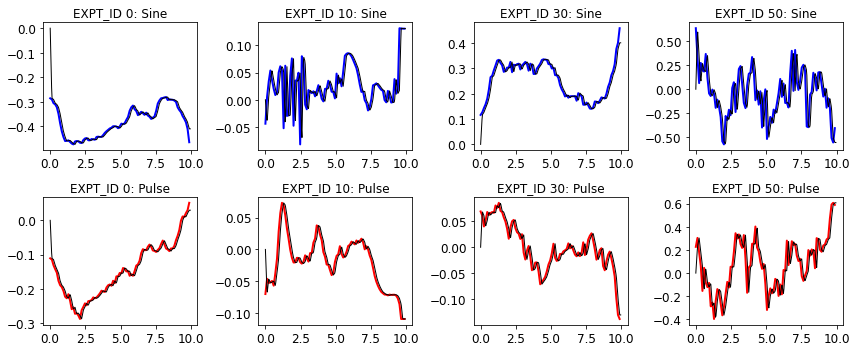

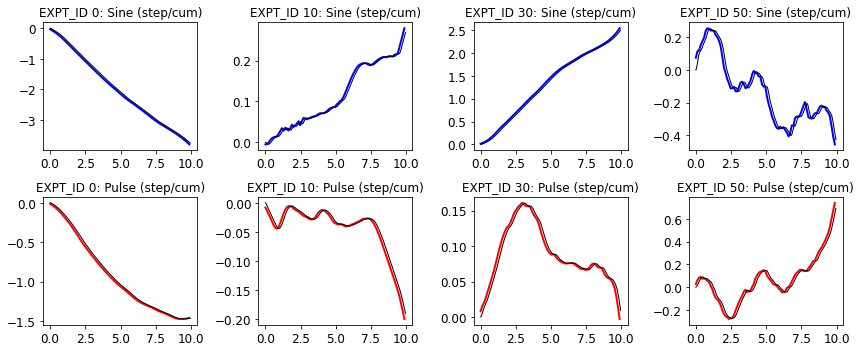

In [8]:
expt_ids = df_lnr_param['EXPT_ID']

r_mins = np.array([df_lnr_param[expt_ids == expt_id].iloc[0]['R_MIN'] for expt_id in expt_ids])
r_maxs = np.array([df_lnr_param[expt_ids == expt_id].iloc[0]['R_MAX'] for expt_id in expt_ids])
z_0s = np.array([df_lnr_param[expt_ids == expt_id].iloc[0]['Z_0'] for expt_id in expt_ids])
betas = np.array([df_lnr_param[expt_ids == expt_id].iloc[0]['BETA'] for expt_id in expt_ids])

# extract filters (downsampled)
hs_dn_s = np.array([df_lnr_param[expt_ids == expt_id].iloc[0][H_S_COLS] for expt_id in expt_ids]).astype(float)
hs_dn_p = np.array([df_lnr_param[expt_ids == expt_id].iloc[0][H_P_COLS] for expt_id in expt_ids]).astype(float)

# # upsample filters via interpolation
hs_s = np.array([np.interp(T_H, T_H_DN, cc([[0], h_dn_s])[:-1]) for h_dn_s in hs_dn_s])
hs_p = np.array([np.interp(T_H, T_H_DN, cc([[0], h_dn_p])[:-1]) for h_dn_p in hs_dn_p])

fig, axs = plt.subplots(2, 4, figsize=(12, 5), tight_layout=True)
for cexpt, ax_col in zip([0, 10, 30, 50], axs.T):
    ax_col[0].plot(T_H_DN, hs_dn_s[cexpt], c='b', lw=2)
    ax_col[0].plot(T_H, hs_s[cexpt], c='k', lw=1)
    ax_col[0].set_title(f'EXPT_ID {expt_ids[cexpt]}: Sine')
    
    ax_col[1].plot(T_H_DN, hs_dn_p[cexpt], c='r', lw=2)
    ax_col[1].plot(T_H, hs_p[cexpt], c='k', lw=1)
    ax_col[1].set_title(f'EXPT_ID {expt_ids[cexpt]}: Pulse')
    
set_font_size(axs, 12)

fig, axs = plt.subplots(2, 4, figsize=(12, 5), tight_layout=True)
for cexpt, ax_col in zip([0, 10, 30, 50], axs.T):
    ax_col[0].plot(T_H_DN, hs_dn_s[cexpt].cumsum()*DT_DN, c='b', lw=2)
    ax_col[0].plot(T_H, hs_s[cexpt].cumsum()*DT, c='k', lw=1)
    ax_col[0].set_title(f'EXPT_ID {expt_ids[cexpt]}: Sine (step/cum)')
    
    ax_col[1].plot(T_H_DN, hs_dn_p[cexpt].cumsum()*DT_DN, c='r', lw=2)
    ax_col[1].plot(T_H, hs_p[cexpt].cumsum()*DT, c='k', lw=1)
    ax_col[1].set_title(f'EXPT_ID {expt_ids[cexpt]}: Pulse (step/cum)')
    
set_font_size(axs, 12)

Neural responses are given by convolution of each neuron's impulse response with song
$$z(t) = h_{sine}(t) \circledast I_{sine}(t) + h_{pulse}(t) \circledast I_{pulse}(t)$$

$$r(t) = r_{min} + (r_{max} - r_{min})\left[\frac{\tanh(\beta(z - z_0)) - 1}{2}\right]$$

In [9]:
def smlt(i_s, i_p, h_s, h_p, r_min, r_max, z_0, beta):
    """Simulate response to song inputs."""
    z = DT*(signal.fftconvolve(i_s, h_s, mode='full')[:len(i_s)] + signal.fftconvolve(i_p, h_p, mode='full')[:len(i_p)])
    
    return r_min + (r_max-r_min)*(np.tanh(beta*(z-z_0)) + 1)/2


# compute surrogate neural responses for each trial
for ctr, df_tr in enumerate(dfs_tr):
    df_tr_nrl_lnr = df_tr.copy()
    sys.stdout.write('.')
    # loop over neurons
    for expt_id, h_s, h_p, r_min, r_max, z_0, beta in zip(expt_ids, hs_s, hs_p, r_mins, r_maxs, z_0s, betas):
        # compute surrogate neural response
        i_s = np.array(df_tr['S']).astype(float)
        i_p = np.array(df_tr['P'] | df_tr['F']).astype(float)
        
        r = smlt(i_s, i_p, h_s, h_p, r_min, r_max, z_0, beta)
        df_tr_nrl_lnr[f'R_{expt_id}'] = r
        
    np.save(os.path.join(SAVE_DIR_LNR, f'{PFX_LNR}_tr_{ctr+CTR_OFFSET}.npy'), np.array([{'df': df_tr_nrl_lnr}]))

....................................................................................

# MA-SOFF: Multiplicative-adaptation neural responses w/ sine-offset responses

Load params from fits to Baker data

In [5]:
# neural response fits from Baker data
df_masoff_param = pd.read_csv('data/simple/neur/baker_masoff_fit_param.csv')
df_masoff_param

,EXPT_ID,LINE,FLY,ROI,ROI_USED,FIT_ERR,SUCCESS,T_0,R_0,TAU_R,TAU_A,X_S,X_P,X_QS,X_PS
0,0,R70G01,0,somas,False,0.275200,True,-0.000000,0.028883,6.202560,30.338151,-4.958240,-2.597416,0.0,0.0
1,1,R70G01,1,somas,False,0.186212,True,0.117647,0.025133,3.835537,21.818473,-4.164089,-1.472157,0.0,0.0
2,2,R70G01,2,somas,False,0.248414,True,-0.000000,0.055965,6.017155,15.057796,-6.248048,-2.095966,0.0,0.0
3,3,R70G01,3,somas,False,0.455963,True,-0.000000,-0.014222,6.016732,11.820065,-5.679817,-2.118260,0.0,0.0
4,4,R70G01,4,somas,False,0.229018,True,-0.000000,0.019839,6.434871,55.490979,-4.415793,-2.863646,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,219,VT34811,0,somas,False,0.276088,True,-0.000000,0.039049,1.801211,1186.088483,-0.049827,2.496913,0.0,0.0
220,220,VT34811,0,ascending projection,False,0.037801,True,-0.000000,-0.001886,1.298842,27.643238,0.098451,2.457383,0.0,0.0
221,221,vPN1_split,0,somas,False,0.404112,True,-0.588235,-0.014702,4.151231,6.155540,8.332275,2.353221,0.0,0.0
222,222,vPN1_split,1,somas,False,1.205977,True,0.235294,-0.095622,5.922635,90.755820,2.390309,0.604363,0.0,0.0


In [6]:
expt_ids = df_masoff_param['EXPT_ID']

# get parameters
tau_rs = np.array(df_masoff_param['TAU_R'])
tau_as = np.array(df_masoff_param['TAU_A'])
x_s_all = np.array(df_masoff_param['X_S'])
x_p_all = np.array(df_masoff_param['X_P'])
x_qs_all = np.array(df_masoff_param['X_QS'])
x_ps_all = np.array(df_masoff_param['X_PS'])

In [7]:
from aux import get_sine_off_cur

# define smln & obj function
def smlt(i_s, i_p, tau_r, tau_a, x_s, x_p, x_qs, x_ps):
    """Simulate response to song inputs."""
    
    i_s, i_p, i_qs, i_ps = get_sine_off_cur(i_s, i_p)[:4]
    
    t = np.arange(len(i_s))*DT
    r = np.nan*np.zeros(len(t))
    
    r[0] = 0
    a_s, a_p, a_qs, a_ps = 0, 0, 0, 0
    
    for ct, t_ in enumerate(t[1:], 1):
        a_s += ((DT/tau_a) * (-a_s + i_s[ct]))
        a_p += ((DT/tau_a) * (-a_p + i_p[ct]))
        a_qs += ((DT/tau_a) * (-a_qs + i_qs[ct]))
        a_ps += ((DT/tau_a) * (-a_ps + i_ps[ct]))
        r[ct] = r[ct-1] + (DT/tau_r) * (-r[ct-1] + (1 - a_s)*x_s*i_s[ct] + (1 - a_p)*x_p*i_p[ct] + (1 - a_qs)*x_qs*i_qs[ct] + (1 - a_ps)*x_ps*i_ps[ct])
    
    return r

In [9]:
# compute surrogate neural responses for each trial
for ctr, df_tr in enumerate(dfs_tr):
    df_tr_nrl_masoff = df_tr.copy()
    sys.stdout.write('.')
    # loop over neurons
    for expt_id, tau_r, tau_a, x_s, x_p, x_qs, x_ps in zip(expt_ids, tau_rs, tau_as, x_s_all, x_p_all, x_qs_all, x_ps_all):
        # compute surrogate neural response
        i_s = np.array(df_tr['S']).astype(float)
        i_p = np.array(df_tr['P'] | df_tr['F']).astype(float)
        
        r = smlt(i_s, i_p, tau_r, tau_a, x_s, x_p, x_qs, x_ps)
        
        df_tr_nrl_masoff[f'R_{expt_id}'] = r
        
    np.save(os.path.join(SAVE_DIR_MASOFF, f'{PFX_MASOFF}_tr_{ctr+CTR_OFFSET}.npy'), np.array([{'df': df_tr_nrl_masoff}]))

....................................................................................................................................................................................................................................................................................

# MA-QS: Multiplicative-adaptation neural responses w/ post-sine quiet responses but not post-sine pulse resposnes

Load params from fits to Baker data

In [13]:
SAVE_DIR_MAQS = 'data/simple/mlv/neur_basic/baker_maqs'
PFX_MAQS = 'mlv_baker_maqs'

if not os.path.exists(SAVE_DIR_MAQS):
    os.makedirs(SAVE_DIR_MAQS)
    
# neural response fits from Baker data
df_masoff_param = pd.read_csv('data/simple/neur/baker_masoff_fit_param.csv')
df_masoff_param

,EXPT_ID,LINE,FLY,ROI,ROI_USED,FIT_ERR,SUCCESS,T_0,R_0,TAU_R,TAU_A,X_S,X_P,X_QS,X_PS
0,0,R70G01,0,somas,False,0.275200,True,-0.000000,0.028883,6.202560,30.338151,-4.958240,-2.597416,0.0,0.0
1,1,R70G01,1,somas,False,0.186212,True,0.117647,0.025133,3.835537,21.818473,-4.164089,-1.472157,0.0,0.0
2,2,R70G01,2,somas,False,0.248414,True,-0.000000,0.055965,6.017155,15.057796,-6.248048,-2.095966,0.0,0.0
3,3,R70G01,3,somas,False,0.455963,True,-0.000000,-0.014222,6.016732,11.820065,-5.679817,-2.118260,0.0,0.0
4,4,R70G01,4,somas,False,0.229018,True,-0.000000,0.019839,6.434871,55.490979,-4.415793,-2.863646,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,219,VT34811,0,somas,False,0.276088,True,-0.000000,0.039049,1.801211,1186.088483,-0.049827,2.496913,0.0,0.0
220,220,VT34811,0,ascending projection,False,0.037801,True,-0.000000,-0.001886,1.298842,27.643238,0.098451,2.457383,0.0,0.0
221,221,vPN1_split,0,somas,False,0.404112,True,-0.588235,-0.014702,4.151231,6.155540,8.332275,2.353221,0.0,0.0
222,222,vPN1_split,1,somas,False,1.205977,True,0.235294,-0.095622,5.922635,90.755820,2.390309,0.604363,0.0,0.0


In [14]:
expt_ids = df_masoff_param['EXPT_ID']

# get parameters
tau_rs = np.array(df_masoff_param['TAU_R'])
tau_as = np.array(df_masoff_param['TAU_A'])
x_s_all = np.array(df_masoff_param['X_S'])
x_p_all = np.array(df_masoff_param['X_P'])
x_qs_all = np.array(df_masoff_param['X_QS'])
x_ps_all = np.array(df_masoff_param['X_PS'])*0

In [15]:
from aux import get_sine_off_cur

# define smln & obj function
def smlt(i_s, i_p, tau_r, tau_a, x_s, x_p, x_qs, x_ps):
    """Simulate response to song inputs."""
    
    i_s, i_p, i_qs, i_ps = get_sine_off_cur(i_s, i_p)[:4]
    
    t = np.arange(len(i_s))*DT
    r = np.nan*np.zeros(len(t))
    
    r[0] = 0
    a_s, a_p, a_qs, a_ps = 0, 0, 0, 0
    
    for ct, t_ in enumerate(t[1:], 1):
        a_s += ((DT/tau_a) * (-a_s + i_s[ct]))
        a_p += ((DT/tau_a) * (-a_p + i_p[ct]))
        a_qs += ((DT/tau_a) * (-a_qs + i_qs[ct]))
        a_ps += ((DT/tau_a) * (-a_ps + i_ps[ct]))
        r[ct] = r[ct-1] + (DT/tau_r) * (-r[ct-1] + (1 - a_s)*x_s*i_s[ct] + (1 - a_p)*x_p*i_p[ct] + (1 - a_qs)*x_qs*i_qs[ct] + (1 - a_ps)*x_ps*i_ps[ct])
    
    return r

In [16]:
# compute surrogate neural responses for each trial
for ctr, df_tr in enumerate(dfs_tr):
    df_tr_nrl_maqs = df_tr.copy()
    sys.stdout.write('.')
    # loop over neurons
    for expt_id, tau_r, tau_a, x_s, x_p, x_qs, x_ps in zip(expt_ids, tau_rs, tau_as, x_s_all, x_p_all, x_qs_all, x_ps_all):
        # compute surrogate neural response
        i_s = np.array(df_tr['S']).astype(float)
        i_p = np.array(df_tr['P'] | df_tr['F']).astype(float)
        
        r = smlt(i_s, i_p, tau_r, tau_a, x_s, x_p, x_qs, x_ps)
        
        df_tr_nrl_maqs[f'R_{expt_id}'] = r
        
    np.save(os.path.join(SAVE_DIR_MAQS, f'{PFX_MAQS}_tr_{ctr+CTR_OFFSET}.npy'), np.array([{'df': df_tr_nrl_maqs}]))

....................................................................................................................................................................................................................................................................................

# MAQSRB: Multiplicative-adaptation neural responses w/ post-sine (quiet) rebound responses that depend on sine adaptation param

$$\tau_r \frac{dr}{dt} = -r + (1-a_s)x_sI_s(t) + (1-a_p)x_pI_p(t) + a_sx_{q/s}I_{q/s}$$

$$\tau_a \frac{da_s}{dt} = -a_s + I_s(t) \quad\quad\quad \tau_a \frac{da_p}{dt} = -a_p + I_p(t)$$

MAQSRB (MA post-sine quiet rebound)

Load params from fits to Baker data

In [4]:
SAVE_DIR_MAQSRB = 'data/simple/mlv/neur_basic/baker_maqsrb'
PFX_MAQSRB = 'mlv_baker_maqsrb'

if not os.path.exists(SAVE_DIR_MAQSRB):
    os.makedirs(SAVE_DIR_MAQSRB)
    
# neural response fits from Baker data
df_masoff_param = pd.read_csv('data/simple/neur/baker_masoff_fit_param.csv')
df_masoff_param

,EXPT_ID,LINE,FLY,ROI,ROI_USED,FIT_ERR,SUCCESS,T_0,R_0,TAU_R,TAU_A,X_S,X_P,X_QS,X_PS
0,0,R70G01,0,somas,False,0.275200,True,-0.000000,0.028883,6.202560,30.338151,-4.958240,-2.597416,0.0,0.0
1,1,R70G01,1,somas,False,0.186212,True,0.117647,0.025133,3.835537,21.818473,-4.164089,-1.472157,0.0,0.0
2,2,R70G01,2,somas,False,0.248414,True,-0.000000,0.055965,6.017155,15.057796,-6.248048,-2.095966,0.0,0.0
3,3,R70G01,3,somas,False,0.455963,True,-0.000000,-0.014222,6.016732,11.820065,-5.679817,-2.118260,0.0,0.0
4,4,R70G01,4,somas,False,0.229018,True,-0.000000,0.019839,6.434871,55.490979,-4.415793,-2.863646,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,219,VT34811,0,somas,False,0.276088,True,-0.000000,0.039049,1.801211,1186.088483,-0.049827,2.496913,0.0,0.0
220,220,VT34811,0,ascending projection,False,0.037801,True,-0.000000,-0.001886,1.298842,27.643238,0.098451,2.457383,0.0,0.0
221,221,vPN1_split,0,somas,False,0.404112,True,-0.588235,-0.014702,4.151231,6.155540,8.332275,2.353221,0.0,0.0
222,222,vPN1_split,1,somas,False,1.205977,True,0.235294,-0.095622,5.922635,90.755820,2.390309,0.604363,0.0,0.0


In [5]:
expt_ids = df_masoff_param['EXPT_ID']

# get parameters
tau_rs = np.array(df_masoff_param['TAU_R'])
tau_as = np.array(df_masoff_param['TAU_A'])
x_s_all = np.array(df_masoff_param['X_S'])
x_p_all = np.array(df_masoff_param['X_P'])
x_qs_all = np.array(df_masoff_param['X_QS'])
x_ps_all = np.array(df_masoff_param['X_PS'])*0

In [6]:
from aux import get_sine_off_cur

# define smln & obj function
def smlt(i_s, i_p, tau_r, tau_a, x_s, x_p, x_qs, x_ps):
    """Simulate response to song inputs."""
    
    i_s, i_p, i_qs, i_ps = get_sine_off_cur(i_s, i_p)[:4]
    
    t = np.arange(len(i_s))*DT
    r = np.nan*np.zeros(len(t))
    
    r[0] = 0
    a_s, a_p = 0, 0
    
    for ct, t_ in enumerate(t[1:], 1):
        a_s += ((DT/tau_a) * (-a_s + i_s[ct]))
        a_p += ((DT/tau_a) * (-a_p + i_p[ct]))
        r[ct] = r[ct-1] + (DT/tau_r) * (-r[ct-1] + (1 - a_s)*x_s*i_s[ct] + (1 - a_p)*x_p*i_p[ct] + a_s*x_qs*i_qs[ct])
    
    return r

In [8]:
# compute surrogate neural responses for each trial
for ctr, df_tr in enumerate(dfs_tr):
    df_tr_nrl_maqsrb = df_tr.copy()
    sys.stdout.write('.')
    # loop over neurons
    for expt_id, tau_r, tau_a, x_s, x_p, x_qs, x_ps in zip(expt_ids, tau_rs, tau_as, x_s_all, x_p_all, x_qs_all, x_ps_all):
        # compute surrogate neural response
        i_s = np.array(df_tr['S']).astype(float)
        i_p = np.array(df_tr['P'] | df_tr['F']).astype(float)
        
        r = smlt(i_s, i_p, tau_r, tau_a, x_s, x_p, x_qs, x_ps)
        
        df_tr_nrl_maqsrb[f'R_{expt_id}'] = r
        
    np.save(os.path.join(SAVE_DIR_MAQSRB, f'{PFX_MAQSRB}_tr_{ctr+CTR_OFFSET}.npy'), np.array([{'df': df_tr_nrl_maqsrb}]))

....................................................................................................................................................................................................................................................................................

# MAQPSRB: Multiplicative-adaptation neural responses w/ post-sine (quiet & pulse) rebound responses that depend on sine adaptation param

$$\tau_r \frac{dr}{dt} = -r + (1-a_s)x_sI_s(t) + (1-a_p)x_pI_p(t) + a_sx_{q/s}I_{q/s} + a_sx_{p/s}I_{p/s}$$

$$\tau_a \frac{da_s}{dt} = -a_s + I_s(t) \quad\quad\quad \tau_a \frac{da_p}{dt} = -a_p + I_p(t)$$

Load params from fits to Baker data

In [4]:
SAVE_DIR_MAQPSRB = 'data/simple/mlv/neur_basic/baker_maqpsrb'
PFX_MAQPSRB = 'mlv_baker_maqpsrb'

if not os.path.exists(SAVE_DIR_MAQPSRB):
    os.makedirs(SAVE_DIR_MAQPSRB)
    
# neural response fits from Baker data
df_masoff_param = pd.read_csv('data/simple/neur/baker_masoff_fit_param.csv')
df_masoff_param

,EXPT_ID,LINE,FLY,ROI,ROI_USED,FIT_ERR,SUCCESS,T_0,R_0,TAU_R,TAU_A,X_S,X_P,X_QS,X_PS
0,0,R70G01,0,somas,False,0.275200,True,-0.000000,0.028883,6.202560,30.338151,-4.958240,-2.597416,0.0,0.0
1,1,R70G01,1,somas,False,0.186212,True,0.117647,0.025133,3.835537,21.818473,-4.164089,-1.472157,0.0,0.0
2,2,R70G01,2,somas,False,0.248414,True,-0.000000,0.055965,6.017155,15.057796,-6.248048,-2.095966,0.0,0.0
3,3,R70G01,3,somas,False,0.455963,True,-0.000000,-0.014222,6.016732,11.820065,-5.679817,-2.118260,0.0,0.0
4,4,R70G01,4,somas,False,0.229018,True,-0.000000,0.019839,6.434871,55.490979,-4.415793,-2.863646,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,219,VT34811,0,somas,False,0.276088,True,-0.000000,0.039049,1.801211,1186.088483,-0.049827,2.496913,0.0,0.0
220,220,VT34811,0,ascending projection,False,0.037801,True,-0.000000,-0.001886,1.298842,27.643238,0.098451,2.457383,0.0,0.0
221,221,vPN1_split,0,somas,False,0.404112,True,-0.588235,-0.014702,4.151231,6.155540,8.332275,2.353221,0.0,0.0
222,222,vPN1_split,1,somas,False,1.205977,True,0.235294,-0.095622,5.922635,90.755820,2.390309,0.604363,0.0,0.0


In [5]:
expt_ids = df_masoff_param['EXPT_ID']

# get parameters
tau_rs = np.array(df_masoff_param['TAU_R'])
tau_as = np.array(df_masoff_param['TAU_A'])
x_s_all = np.array(df_masoff_param['X_S'])
x_p_all = np.array(df_masoff_param['X_P'])
x_qs_all = np.array(df_masoff_param['X_QS'])
x_ps_all = np.array(df_masoff_param['X_PS'])

In [6]:
from aux import get_sine_off_cur

# define smln & obj function
def smlt(i_s, i_p, tau_r, tau_a, x_s, x_p, x_qs, x_ps):
    """Simulate response to song inputs."""
    
    i_s, i_p, i_qs, i_ps = get_sine_off_cur(i_s, i_p)[:4]
    
    t = np.arange(len(i_s))*DT
    r = np.nan*np.zeros(len(t))
    
    r[0] = 0
    a_s, a_p = 0, 0
    
    for ct, t_ in enumerate(t[1:], 1):
        a_s += ((DT/tau_a) * (-a_s + i_s[ct]))
        a_p += ((DT/tau_a) * (-a_p + i_p[ct]))
        r[ct] = r[ct-1] + (DT/tau_r) * (-r[ct-1] + (1 - a_s)*x_s*i_s[ct] + (1 - a_p)*x_p*i_p[ct] + a_s*x_qs*i_qs[ct] + a_s*x_ps*i_ps[ct])
    
    return r

In [ ]:
# compute surrogate neural responses for each trial
for ctr, df_tr in enumerate(dfs_tr):
    df_tr_nrl_maqpsrb = df_tr.copy()
    sys.stdout.write('.')
    # loop over neurons
    for expt_id, tau_r, tau_a, x_s, x_p, x_qs, x_ps in zip(expt_ids, tau_rs, tau_as, x_s_all, x_p_all, x_qs_all, x_ps_all):
        # compute surrogate neural response
        i_s = np.array(df_tr['S']).astype(float)
        i_p = np.array(df_tr['P'] | df_tr['F']).astype(float)
        
        r = smlt(i_s, i_p, tau_r, tau_a, x_s, x_p, x_qs, x_ps)
        
        df_tr_nrl_maqpsrb[f'R_{expt_id}'] = r
        
    np.save(os.path.join(SAVE_DIR_MAQPSRB, f'{PFX_MAQPSRB}_tr_{ctr+CTR_OFFSET}.npy'), np.array([{'df': df_tr_nrl_maqpsrb}]))

..